## Adventure Works analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from sqlalchemy import create_engine

## Connection with database

In [2]:
SERVER = 'LAPTOP-427MMEBJ\MULTIDIMENSIONAL'
DATABASE = 'AdventureWorks2019'
DRIVER = 'SQL Server'
DATABASE_CONNECTION = f'mssql://@{SERVER}/{DATABASE}?driver={DRIVER}'

engine = create_engine(DATABASE_CONNECTION)
conn = engine.connect()

#### How many and which products were saled in 2013

In [3]:
saleProducts = '''
        SELECT p.Name, SUM(sod.OrderQty) AS TotalSales
        FROM Production.Product p
        JOIN Sales.SalesOrderDetail sod ON sod.ProductID = p.ProductID
        JOIN Sales.SalesOrderHeader soh ON soh.SalesOrderID = sod.SalesOrderID
        WHERE YEAR(soh.OrderDate) = 2013
        GROUP BY p.Name
        ORDER BY TotalSales DESC
'''

In [4]:
sales2013 = pd.read_sql_query(saleProducts,conn)
sales2013.head(10)

,Name,TotalSales
0,Water Bottle - 30 oz.,3913
1,AWC Logo Cap,3768
2,"Sport-100 Helmet, Black",3088
3,"Sport-100 Helmet, Blue",3088
4,"Sport-100 Helmet, Red",2940
5,"Long-Sleeve Logo Jersey, L",2910
6,"Classic Vest, S",2852
7,"Short-Sleeve Classic Jersey, XL",2600
8,"Women's Mountain Shorts, S",2202
9,Bike Wash - Dissolver,2165


#### Chart shows TOP 10 best sold products

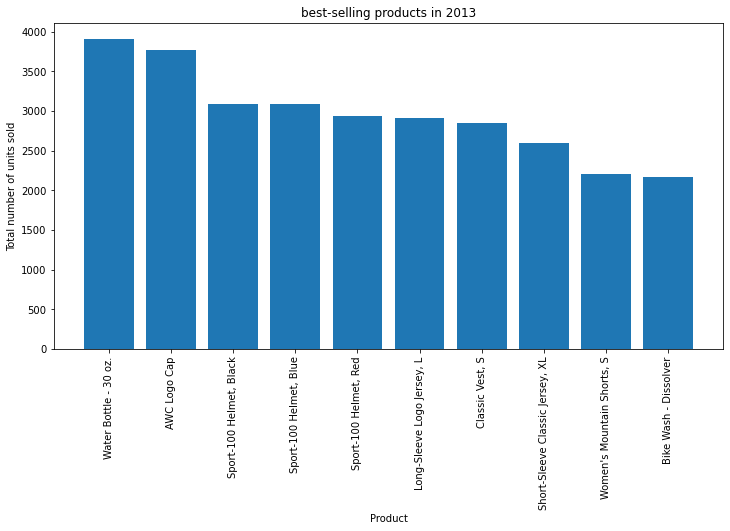

In [5]:
df = sales2013.head(10)

plt.figure(figsize=(12,6))
plt.bar(df['Name'], df['TotalSales'])
plt.xticks(rotation=90)
plt.title('best-selling products in 2013')
plt.xlabel('Product')
plt.ylabel('Total number of units sold')
plt.show()

### Comparison to previous year

In [6]:
comparisonSQL = '''
            WITH Sales2012 AS (
            SELECT 
                p.Name, 
                SUM(sod.OrderQty) AS TotalSales2012
            FROM Sales.SalesOrderDetail sod
            JOIN Production.Product p
                ON sod.ProductID = p.ProductID
            JOIN Sales.SalesOrderHeader  soh
                ON sod.SalesOrderID = soh.SalesOrderID
            WHERE YEAR(soh.OrderDate) = 2012
            GROUP BY p.Name
        ), 
        Sales2013 AS (
            SELECT 
                p.Name, 
                SUM(sod.OrderQty) AS TotalSales2013
            FROM Sales.SalesOrderDetail sod
            JOIN Production.Product p
                ON sod.ProductID = p.ProductID
            JOIN Sales.SalesOrderHeader soh
                ON sod.SalesOrderID = soh.SalesOrderID
            WHERE YEAR(soh.OrderDate) = 2013
            GROUP BY p.Name
        )
        SELECT 
            s1.Name,
            s.TotalSales2012,
            s1.TotalSales2013,
            s1.TotalSales2013 - s.TotalSales2012 AS 'Difference'
        FROM Sales2013 s1
        LEFT JOIN Sales2012 s ON s1.Name = s.Name
        ORDER BY s1.TotalSales2013 DESC;
'''

In [7]:
compare = pd.read_sql_query(comparisonSQL,conn)
compare.head(10)

,Name,TotalSales2012,TotalSales2013,Difference
0,Water Bottle - 30 oz.,NaN,3913,NaN
1,AWC Logo Cap,2048.0,3768,1720.0
2,"Sport-100 Helmet, Black",1387.0,3088,1701.0
3,"Sport-100 Helmet, Blue",1519.0,3088,1569.0
4,"Sport-100 Helmet, Red",1278.0,2940,1662.0
5,"Long-Sleeve Logo Jersey, L",2113.0,2910,797.0
6,"Classic Vest, S",NaN,2852,NaN
7,"Short-Sleeve Classic Jersey, XL",NaN,2600,NaN
8,"Women's Mountain Shorts, S",NaN,2202,NaN
9,Bike Wash - Dissolver,NaN,2165,NaN


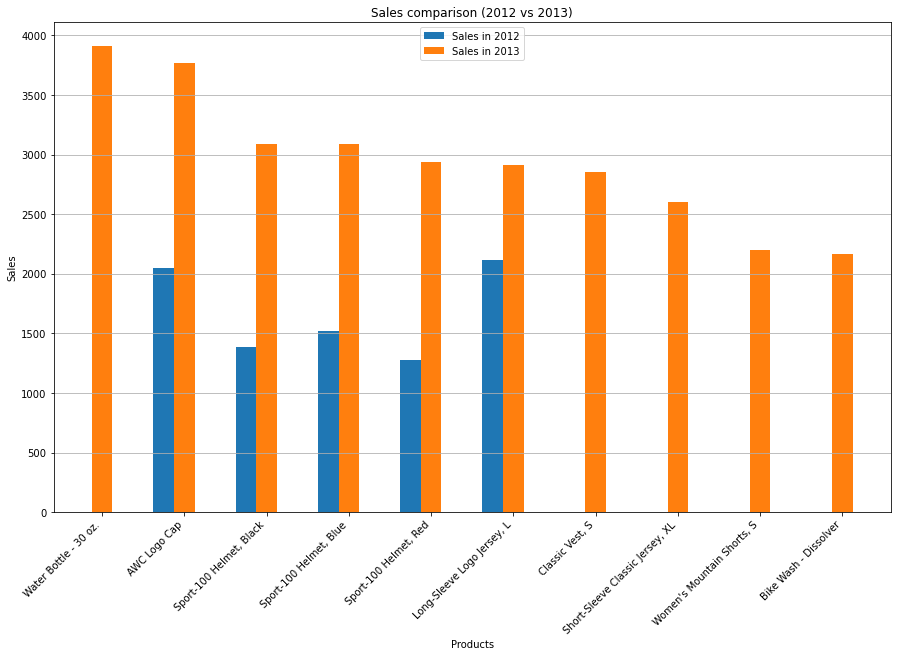

In [8]:
compare = compare.head(10)

products = compare['Name']
sales2012 = compare['TotalSales2012']
sales2013 = compare['TotalSales2013']

fig, ax = plt.subplots(figsize=(15, 10))
ind = np.arange(len(products))
width = 0.25

rects1 = ax.bar(ind - width, sales2012, width, label='Sales in 2012')
rects2 = ax.bar(ind, sales2013, width, label='Sales in 2013')

ax.set_xlabel('Products')
ax.set_ylabel('Sales')
ax.set_title('Sales comparison (2012 vs 2013)')
ax.set_xticks(ind)
ax.set_xticklabels(products, rotation=45, ha='right')
ax.legend()

plt.subplots_adjust(bottom=0.2)
plt.grid(True, axis='y')

plt.show()

### Checking sales by cities in 2013

In [34]:
salesByCitiesSQL = '''
WITH RegionSales AS (
    SELECT
        p.City,
        SUM(sod.OrderQty) AS TotalSales,
        YEAR(soh.OrderDate) AS OrderYear
    FROM Sales.SalesOrderDetail sod
    JOIN Sales.SalesOrderHeader soh
    ON sod.SalesOrderID = soh.SalesOrderID
    JOIN Person.Address p
    ON soh.ShipToAddressID = p.AddressID
    WHERE YEAR(soh.OrderDate) = 2013
    GROUP BY City, YEAR(soh.OrderDate)
    )
    SELECT
        City,
        SUM(TotalSales) AS 'TotalSales'
    FROM RegionSales
    GROUP BY City
    ORDER BY TotalSales DESC
'''

In [35]:
salesByCities = pd.read_sql_query(salesByCitiesSQL,conn)
salesByCities.head(10)

,City,TotalSales
0,Toronto,5826
1,London,3697
2,Paris,2921
3,Burnaby,1941
4,Edmonton,1799
5,Orleans,1716
6,Seattle,1620
7,Montreal,1507
8,Richmond,1490
9,Phoenix,1448


Based on the results of this query, we can conclude that Toronto generates the highest sales among all cities from which orders are delivered. One of the reasons may also be the scale of the company's operations in Toronto - it may have an office, warehouse or distribution center there, which would increase the number of orders and sales in this region.

### Checking total profit based on products in category in 2013

In [11]:
profitSQL = '''
    SELECT 
        pc.Name AS CategoryName, 
        p.Name AS ProductName, 
        SUM(sod.LineTotal) AS TotalProfit
    FROM 
        Production.Product AS p
        INNER JOIN Production.ProductSubcategory AS psc 
            ON p.ProductSubcategoryID = psc.ProductSubcategoryID
        INNER JOIN Production.ProductCategory AS pc 
            ON psc.ProductCategoryID = pc.ProductCategoryID
        INNER JOIN Sales.SalesOrderDetail AS sod 
            ON p.ProductID = sod.ProductID
        INNER JOIN Sales.SalesOrderHeader AS soh
            ON sod.SalesOrderID = soh.SalesOrderID
    WHERE 
        YEAR(soh.OrderDate) = 2013
    GROUP BY 
        pc.Name, 
        p.Name
    ORDER BY 
        pc.Name, 
        TotalProfit DESC;
'''

In [12]:
profit = pd.read_sql_query(profitSQL,conn)
profit['TotalProfit']=profit['TotalProfit'].apply(lambda x: round(x,2))
profit.head(30)

,CategoryName,ProductName,TotalProfit
0,Accessories,Hitch Rack - 4-Bike,155922.76
1,Accessories,"Sport-100 Helmet, Black",76703.60
2,Accessories,"Sport-100 Helmet, Blue",76242.61
3,Accessories,"Sport-100 Helmet, Red",74566.21
4,Accessories,Hydration Pack - 70 oz.,66489.31
5,Accessories,HL Mountain Tire,24745.00
6,Accessories,Fender Set - Mountain,23914.24
7,Accessories,All-Purpose Bike Stand,21624.00
8,Accessories,ML Mountain Tire,18263.91
9,Accessories,Water Bottle - 30 oz.,15753.85


In [13]:
profit.describe().apply(lambda x: round(x,2)).T

,count,mean,std,min,25%,50%,75%,max
TotalProfit,238.0,183287.73,349977.16,162.72,13012.86,49971.86,162904.13,2212974.78


In [14]:
profit['CategoryName'].unique()

array(['Accessories', 'Bikes', 'Clothing', 'Components'], dtype=object)

Based on unique values in the column 'CategoryName', the best profit will be checked for top 10 products

In [15]:
accessories = profit[profit['CategoryName'] =='Accessories']
accessories.head(10)

,CategoryName,ProductName,TotalProfit
0,Accessories,Hitch Rack - 4-Bike,155922.76
1,Accessories,"Sport-100 Helmet, Black",76703.60
2,Accessories,"Sport-100 Helmet, Blue",76242.61
3,Accessories,"Sport-100 Helmet, Red",74566.21
4,Accessories,Hydration Pack - 70 oz.,66489.31
5,Accessories,HL Mountain Tire,24745.00
6,Accessories,Fender Set - Mountain,23914.24
7,Accessories,All-Purpose Bike Stand,21624.00
8,Accessories,ML Mountain Tire,18263.91
9,Accessories,Water Bottle - 30 oz.,15753.85


In [16]:
bikes = profit[profit['CategoryName'] =='Bikes']
bikes.head(10)

,CategoryName,ProductName,TotalProfit
24,Bikes,"Mountain-200 Black, 38",2212974.78
25,Bikes,"Mountain-200 Black, 42",1932388.29
26,Bikes,"Mountain-200 Silver, 38",1815673.09
27,Bikes,"Mountain-200 Black, 46",1666660.02
28,Bikes,"Mountain-200 Silver, 46",1657616.28
29,Bikes,"Mountain-200 Silver, 42",1596847.23
30,Bikes,"Road-250 Black, 44",1262950.16
31,Bikes,"Road-250 Black, 48",1154069.88
32,Bikes,"Road-350-W Yellow, 48",1097415.13
33,Bikes,"Touring-1000 Blue, 60",1086388.75


In [17]:
clothing = profit[profit['CategoryName'] =='Clothing']
clothing.head(10)

,CategoryName,ProductName,TotalProfit
103,Clothing,"Classic Vest, S",103570.71
104,Clothing,"Women's Mountain Shorts, S",89200.55
105,Clothing,"Long-Sleeve Logo Jersey, L",89058.13
106,Clothing,"Women's Mountain Shorts, L",86609.13
107,Clothing,"Short-Sleeve Classic Jersey, XL",84513.63
108,Clothing,"Short-Sleeve Classic Jersey, L",64278.95
109,Clothing,"Classic Vest, M",61255.31
110,Clothing,"Long-Sleeve Logo Jersey, M",53539.50
111,Clothing,"Short-Sleeve Classic Jersey, S",48463.13
112,Clothing,"Long-Sleeve Logo Jersey, XL",41091.28


In [18]:
components = profit[profit['CategoryName'] =='Components']
components.head(10)

,CategoryName,ProductName,TotalProfit
135,Components,"HL Mountain Frame - Silver, 38",411927.21
136,Components,"HL Mountain Frame - Black, 42",390451.56
137,Components,"ML Road Frame-W - Yellow, 44",247936.63
138,Components,"HL Touring Frame - Blue, 54",231571.82
139,Components,"HL Touring Frame - Yellow, 54",225085.86
140,Components,"HL Mountain Frame - Black, 38",208181.94
141,Components,"HL Mountain Frame - Silver, 46",206014.69
142,Components,"HL Road Frame - Black, 44",185756.65
143,Components,"HL Road Frame - Red, 62",182321.05
144,Components,"HL Road Frame - Red, 44",182321.05


#### Which category have the higest total profit

In [19]:
components['TotalProfit'].sum()

5612935.390000001

In [20]:
clothing['TotalProfit'].sum()

1067689.7

In [21]:
bikes['TotalProfit'].sum()

36266829.33

In [22]:
accessories['TotalProfit'].sum()

675024.67

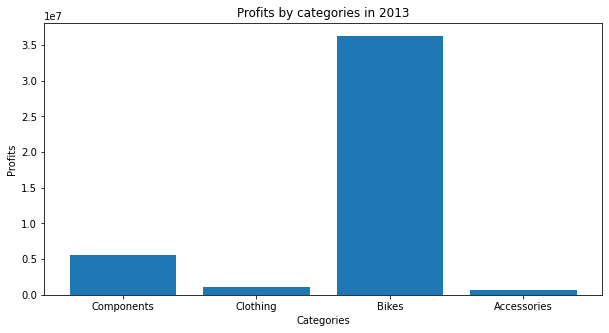

In [23]:
categories = ['Components', 'Clothing', 'Bikes', 'Accessories']
profits = [components['TotalProfit'].sum(),clothing['TotalProfit'].sum(),bikes['TotalProfit'].sum(),accessories['TotalProfit'].sum()]

plt.figure(figsize=(10,5))

plt.bar(categories,profits)

plt.title('Profits by categories in 2013')
plt.xlabel('Categories')
plt.ylabel('Profits')

plt.show()

Conclusion:
The chart shows that the "Clothing", "Accessories" and "Components" categories are significantly less profitable than the "Bikes" category. It can be concluded that these categories are less profitable and perhaps it is worth focusing on increasing their profitability by analyzing and improving marketing activities, adapting the offer to the needs of customers. However, it should be remembered that everything depends on the company's strategy and its goals, and not only on the financial results of individual product categories.

#### Sales comparison between 2012 and 2013 by categories

In [24]:
salesComparisonSQL = '''
    with SalesIn2012 as (
    SELECT 
    pc.Name AS CategoryName, 
    SUM(sod.LineTotal) AS TotalProfit2012
FROM 
    Production.Product AS p
    INNER JOIN Production.ProductSubcategory AS psc 
        ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    INNER JOIN Production.ProductCategory AS pc 
        ON psc.ProductCategoryID = pc.ProductCategoryID
    INNER JOIN Sales.SalesOrderDetail AS sod 
        ON p.ProductID = sod.ProductID
    INNER JOIN Sales.SalesOrderHeader AS soh
        ON sod.SalesOrderID = soh.SalesOrderID
WHERE 
    YEAR(soh.OrderDate) = 2012
GROUP BY 
    pc.Name
),
SalesIn2013 AS (
    SELECT 
    pc.Name AS CategoryName,  
    SUM(sod.LineTotal) AS TotalProfit2013
FROM 
    Production.Product AS p
    INNER JOIN Production.ProductSubcategory AS psc 
        ON p.ProductSubcategoryID = psc.ProductSubcategoryID
    INNER JOIN Production.ProductCategory AS pc 
        ON psc.ProductCategoryID = pc.ProductCategoryID
    INNER JOIN Sales.SalesOrderDetail AS sod 
        ON p.ProductID = sod.ProductID
    INNER JOIN Sales.SalesOrderHeader AS soh
        ON sod.SalesOrderID = soh.SalesOrderID
WHERE 
    YEAR(soh.OrderDate) = 2013
GROUP BY 
    pc.Name
)
SELECT s.CategoryName, 
   s.TotalProfit2012,
   s1.TotalProfit2013,
  s1.TotalProfit2013 - s.TotalProfit2012 AS 'Difference'
FROM SalesIn2012 s
JOIN SalesIn2013 s1
ON s.CategoryName = s1.CategoryName
ORDER BY s.CategoryName
'''

In [25]:
salesComparison = pd.read_sql_query(salesComparisonSQL, conn)
salesComparison

,CategoryName,TotalProfit2012,TotalProfit2013,Difference
0,Accessories,1.024398e+05,6.750247e+05,5.725848e+05
1,Bikes,2.898552e+07,3.626683e+07,7.281314e+06
2,Clothing,5.555877e+05,1.067690e+06,5.121020e+05
3,Components,3.880758e+06,5.612935e+06,1.732177e+06


In [26]:
columns = ['TotalProfit2012','TotalProfit2013', 'Difference']

for i in columns:
    salesComparison[i] = salesComparison[i].astype(int)

In [27]:
salesComparison

,CategoryName,TotalProfit2012,TotalProfit2013,Difference
0,Accessories,102439,675024,572584
1,Bikes,28985515,36266829,7281313
2,Clothing,555587,1067689,512101
3,Components,3880757,5612935,1732177


<Figure size 1440x1080 with 0 Axes>

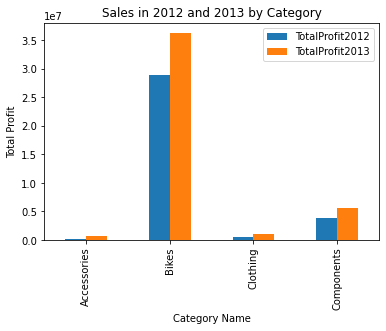

In [30]:
plt.figure(figsize=(20,15))
salesComparison.plot(x='CategoryName', y=['TotalProfit2012', 'TotalProfit2013'], kind='bar')
plt.xlabel('Category Name')
plt.ylabel('Total Profit')
plt.title('Sales in 2012 and 2013 by Category')
plt.show()

Compared to the previous year, there is an increase in sales in each category